In [1]:
import os
from pathlib import Path
import random
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image
from tqdm.auto import tqdm

import torchvision.transforms as T
import torchvision
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights

In [2]:

COMP_PATH = Path("../input/deep-learning-for-computer-vision-and-nlp-2026-01")
FOLDS_PATH = Path("../input/petfinder-train-folds/train_folds.csv")  # зміниться під твою назву на Kaggle

TRAIN_CSV = COMP_PATH / "train.csv"
TEST_CSV  = COMP_PATH / "test.csv"
IMG_DIR_TRAIN   = COMP_PATH / "images/images/train"
IMG_DIR_TEST    = COMP_PATH / "images/images/test"
IMG_DIR = COMP_PATH / "images/images"

print("train exists:", TRAIN_CSV.exists())
print("test exists :", TEST_CSV.exists())
print("images dir  :", IMG_DIR.exists())
print("folds exists:", FOLDS_PATH.exists())

train exists: True
test exists : True
images dir  : True
folds exists: True


In [3]:
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)
folds_df = pd.read_csv(FOLDS_PATH)

print(train_df.shape, test_df.shape, folds_df.shape)
train_df.head()

(6431, 3) (1891, 2) (6431, 3)


,PetID,Description,AdoptionSpeed
0,d3b4f29f8,Mayleen and Flo are two lovely adorable sister...,2
1,e9dc82251,A total of 5 beautiful Tabbys available for ad...,2
2,8111f6d4a,Two-and-a-half month old girl. Very manja and ...,2
3,693a90fda,Neil is a healthy and active ~2-month-old fema...,2
4,9d08c85ef,Gray kitten available for adoption in sungai p...,2


In [4]:
train_df = train_df.merge(folds_df, on=["PetID", "AdoptionSpeed"], how="left")
print("after merge:", train_df.shape)
train_df[["PetID","AdoptionSpeed","fold"]].head()

after merge: (6431, 4)


,PetID,AdoptionSpeed,fold
0,d3b4f29f8,2,3
1,e9dc82251,2,3
2,8111f6d4a,2,2
3,693a90fda,2,4
4,9d08c85ef,2,3


In [5]:
train_imgs = list(IMG_DIR_TRAIN.glob("*"))
print("total image files:", len(train_imgs))
print("sample:", [p.name for p in train_imgs[:10]])

total image files: 28472
sample: ['61d4dc56b-12.jpg', '53923463d-9.jpg', '0173c456c-8.jpg', 'fa7c7d1be-3.jpg', '1a030d758-1.jpg', 'd9f692e74-2.jpg', 'ebc345fe0-4.jpg', '2c24655fe-6.jpg', '94438a5c5-4.jpg', 'c9ff29578-13.jpg']


In [6]:
# Check matching between image files and CSV PetIDs

petids_in_csv = set(train_df["PetID"].astype(str))

sample_files = random.sample(train_imgs, 200)
prefixes = [p.name.split("-", 1)[0] for p in sample_files]

match_rate = sum(pref in petids_in_csv for pref in prefixes) / len(prefixes)

print("Match rate:", match_rate)
print("Example prefixes:", prefixes[:10])

Match rate: 1.0
Example prefixes: ['abfcb22bc', '0d20efa95', '3cc84c2f8', '4fbe0c2e5', 'd9f692e74', 'b8d07c37b', '0e88c1c1c', 'f90f6ca1a', '339a623c4', '087804d85']


In [7]:
petid_to_images = defaultdict(list)

for img_path in train_imgs:
    pet_id = img_path.name.split("-", 1)[0]
    petid_to_images[pet_id].append(img_path)

print("Total PetIDs with images:", len(petid_to_images))

Total PetIDs with images: 6431


In [8]:
test_imgs = list(IMG_DIR_TEST.glob("*"))
print("total image files:", len(test_imgs))
print("sample:", [p.name for p in test_imgs[:10]])

total image files: 9448
sample: ['cf8d949f9-2.jpg', '41e824cbe-3.jpg', '687be6419-4.jpg', '081199ea2-12.jpg', '924cc5438-4.jpg', 'b1ed265ef-11.jpg', '9daaa4e8f-1.jpg', '062de1f53-4.jpg', '0ce5d0b5f-3.jpg', 'd4bb8cf0a-4.jpg']


In [9]:
petids_in_csv = set(test_df["PetID"].astype(str))

sample_files = random.sample(test_imgs, 200)
prefixes = [p.name.split("-", 1)[0] for p in sample_files]

match_rate = sum(pref in petids_in_csv for pref in prefixes) / len(prefixes)

print("Match rate:", match_rate)
print("Example prefixes:", prefixes[:10])

Match rate: 0.995
Example prefixes: ['f394d4aad', 'ba7b8cac2', '8edd5d505', '2107c9788', '7268e9e21', 'fa1c96e93', 'aa4b23487', '6df350974', 'a17411df1', '4133efff0']


In [10]:
# example output
some_pet = list(petid_to_images.keys())[3]
print(some_pet)
print(petid_to_images[some_pet])

fa7c7d1be
[PosixPath('../input/deep-learning-for-computer-vision-and-nlp-2026-01/images/images/train/fa7c7d1be-3.jpg'), PosixPath('../input/deep-learning-for-computer-vision-and-nlp-2026-01/images/images/train/fa7c7d1be-1.jpg'), PosixPath('../input/deep-learning-for-computer-vision-and-nlp-2026-01/images/images/train/fa7c7d1be-2.jpg'), PosixPath('../input/deep-learning-for-computer-vision-and-nlp-2026-01/images/images/train/fa7c7d1be-4.jpg')]


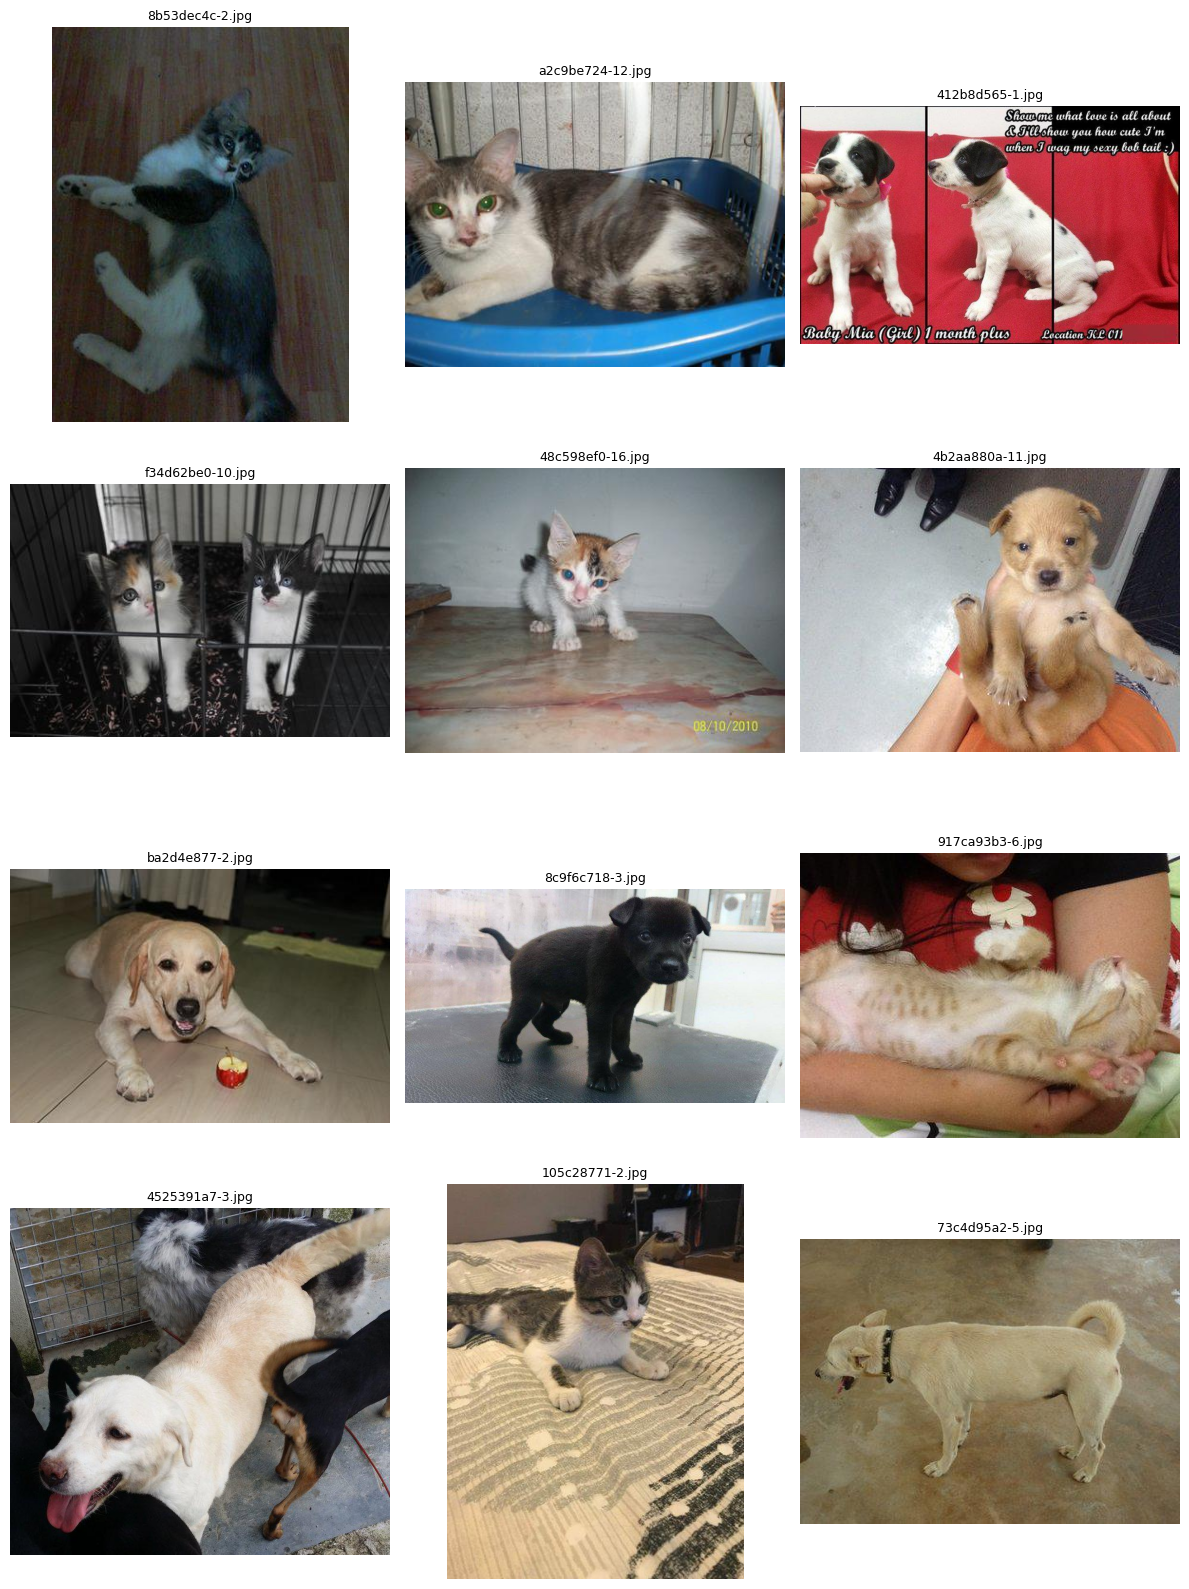

In [11]:
n_rows, n_cols = 4, 3
n = n_rows * n_cols

sample_paths = random.sample(train_imgs, k=n)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 16))
axes = axes.flatten()

for ax, p in zip(axes, sample_paths):
    img = Image.open(p).convert("RGB")
    ax.imshow(img)
    ax.set_title(p.name, fontsize=9)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [12]:
class PetDataset(Dataset):
    def __init__(self, df, petid_to_images, transform=None):
        self.transform = transform
        self.samples = []

        df = df.reset_index(drop=True)
        for _, row in df.iterrows():
            pet_id = str(row["PetID"])
            label = row["AdoptionSpeed"] - 1  # 0..3

            paths = petid_to_images.get(pet_id, [])
            for p in paths:
                self.samples.append((p, label, pet_id))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label, pet_id = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label, pet_id

In [13]:
IMG_SIZE = 380

weights = EfficientNet_B4_Weights.DEFAULT
mean = weights.transforms().mean
std  = weights.transforms().std

train_tfms = T.Compose([
    T.RandomResizedCrop(IMG_SIZE, scale=(0.70, 1.0), ratio=(0.9, 1.1)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
    T.RandomErasing(p=0.25, scale=(0.02, 0.15), ratio=(0.3, 3.3), value="random"),
])

val_tfms = T.Compose([
    T.Resize(436),          # ~ IMG_SIZE / 0.87
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
])

In [14]:
FOLD=0
df_tr = train_df[train_df["fold"] != FOLD].reset_index(drop=True)
df_va = train_df[train_df["fold"] == FOLD].reset_index(drop=True)

train_ds = PetDataset(df_tr, petid_to_images, transform=train_tfms)
val_ds   = PetDataset(df_va, petid_to_images, transform=val_tfms)

len(train_ds), len(val_ds)

(22797, 5675)

In [15]:
BATCH_SIZE = 8
NUM_WORKERS = 2 
N_SPLITS = 5
EPOCHS = 6
LR = 1e-4     
PIN_MEMORY  = True

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,     
    drop_last=False       
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    drop_last=False
)

print("train batches:", len(train_loader))
print("val batches  :", len(val_loader))

train batches: 2850
val batches  : 710


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [17]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()  # режим навчання (вмикає dropout, batchnorm у train-режимі)

    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc="train", leave=False)

    for x, y, _ in pbar:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()          # обнуляємо градієнти
        logits = model(x)              # прямий прохід
        loss = criterion(logits, y)    # рахуємо loss

        loss.backward()                # зворотний прохід (градієнти)
        optimizer.step()               # крок оптимізатора

        bs = x.size(0)
        running_loss += loss.item() * bs
        total += bs

        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()

        pbar.set_postfix(loss=float(loss.item()))

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [18]:
@torch.no_grad()
def valid_epoch_with_probs(model, loader, criterion, device):
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    probs_list = []
    petids_list = []
    labels_list = []

    pbar = tqdm(loader, desc="valid", leave=False)

    for x, y, pet_id in pbar:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        bs = x.size(0)
        running_loss += loss.item() * bs
        total += bs

        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()

        probs = F.softmax(logits, dim=1).cpu().numpy()  # (bs, 4)
        probs_list.append(probs)

        # pet_id може бути list[str] або tuple[str]
        petids_list.extend(list(pet_id))
        labels_list.extend(y.cpu().numpy().tolist())

        pbar.set_postfix(loss=float(loss.item()))

    val_loss = running_loss / total
    val_acc = correct / total

    probs_all = np.vstack(probs_list)          # (N_images, 4)
    petids_all = np.array(petids_list)         # (N_images,)
    labels_all = np.array(labels_list)         # (N_images,)

    # агрегуємо по PetID: mean probs, label беремо перший
    df = pd.DataFrame(probs_all, columns=["p0","p1","p2","p3"])
    df["PetID"] = petids_all
    df["label"] = labels_all

    df_pet = df.groupby("PetID", as_index=False).agg({
        "p0":"mean","p1":"mean","p2":"mean","p3":"mean","label":"first"
    })

    val_probs_pet = df_pet[["p0","p1","p2","p3"]].values     # (N_pets, 4)
    val_labels_pet = df_pet["label"].values                  # (N_pets,)

    return val_loss, val_acc, val_probs_pet, val_labels_pet, df_pet[["PetID"]]

In [19]:
def build_model():
    model = torchvision.models.efficientnet_b4(
        weights=EfficientNet_B4_Weights.DEFAULT
    )
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 4)
    return model

In [20]:
def build_optimizer(model):
    return torch.optim.AdamW(
        model.parameters(),
        lr=LR,
        weight_decay=1e-4
    )

In [21]:
def build_criterion():
    return nn.CrossEntropyLoss()

In [22]:
oof_parts = []   # сюди складемо OOF з кожного фолда

for FOLD in range(N_SPLITS):
    print(f"\n===== FOLD {FOLD} =====")

    # 1) split
    df_tr = train_df[train_df["fold"] != FOLD].reset_index(drop=True)
    df_va = train_df[train_df["fold"] == FOLD].reset_index(drop=True)

    # 2) datasets/loaders
    train_ds = PetDataset(df_tr, petid_to_images, transform=train_tfms)
    val_ds   = PetDataset(df_va, petid_to_images, transform=val_tfms)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=False)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=False)

    # 3) model/opt
    model = build_model().to(device)          # твоя функція створення EfficientNet-B4
    optimizer = build_optimizer(model)        # AdamW/Adam
    criterion = build_criterion()             # CrossEntropyLoss

    best_qwk = -1e9
    best_oof_fold = None

    # 4) epochs loop
    for epoch in range(1, EPOCHS + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)

        val_loss, val_acc, val_probs_pet, val_labels_pet, val_petids = valid_epoch_with_probs(
            model, val_loader, criterion, device
        )

        val_pred = val_probs_pet.argmax(axis=1)
        val_qwk = cohen_kappa_score(val_labels_pet + 1, val_pred + 1, weights="quadratic")

        print(f"Epoch {epoch}/{EPOCHS} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | QWK={val_qwk:.4f}")

        # 5) зберігаємо найкращий OOF для цього фолда
        if val_qwk > best_qwk:
            best_qwk = val_qwk
            pet_ids = val_petids["PetID"].values
            best_oof_fold = pd.DataFrame({
                "PetID": pet_ids,
                "pred_0": val_probs_pet[:, 0],
                "pred_1": val_probs_pet[:, 1],
                "pred_2": val_probs_pet[:, 2],
                "pred_3": val_probs_pet[:, 3],
                "fold": FOLD
            })

    # 6) після епох — додаємо OOF цього фолда
    assert best_oof_fold is not None, f"OOF for fold {FOLD} is None"
    oof_parts.append(best_oof_fold)
    print(f"FOLD {FOLD} best_QWK={best_qwk:.4f}")

# 7) після всіх фолдів — склеюємо OOF
df_oof_all = pd.concat(oof_parts, ignore_index=True)


===== FOLD 0 =====
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth


100%|██████████| 74.5M/74.5M [00:00<00:00, 210MB/s]


train:   0%|          | 0/2850 [00:00<?, ?it/s]

valid:   0%|          | 0/710 [00:00<?, ?it/s]

Epoch 1/6 | train_loss=1.2363 | val_loss=1.2271 | QWK=0.4836


train:   0%|          | 0/2850 [00:00<?, ?it/s]

valid:   0%|          | 0/710 [00:00<?, ?it/s]

Epoch 2/6 | train_loss=1.1341 | val_loss=1.2185 | QWK=0.5000


train:   0%|          | 0/2850 [00:00<?, ?it/s]

valid:   0%|          | 0/710 [00:00<?, ?it/s]

Epoch 3/6 | train_loss=1.0320 | val_loss=1.3078 | QWK=0.4662


train:   0%|          | 0/2850 [00:00<?, ?it/s]

Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

valid:   0%|          | 0/710 [00:00<?, ?it/s]

Epoch 4/6 | train_loss=0.9232 | val_loss=1.3670 | QWK=0.4705


train:   0%|          | 0/2850 [00:00<?, ?it/s]

valid:   0%|          | 0/710 [00:00<?, ?it/s]

Epoch 5/6 | train_loss=0.8085 | val_loss=1.4475 | QWK=0.4446


train:   0%|          | 0/2850 [00:00<?, ?it/s]

valid:   0%|          | 0/710 [00:00<?, ?it/s]

Epoch 6/6 | train_loss=0.6867 | val_loss=1.6289 | QWK=0.4238
FOLD 0 best_QWK=0.5000

===== FOLD 1 =====


train:   0%|          | 0/2870 [00:00<?, ?it/s]

valid:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 1/6 | train_loss=1.2366 | val_loss=1.2145 | QWK=0.5158


train:   0%|          | 0/2870 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

valid:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 2/6 | train_loss=1.1356 | val_loss=1.2356 | QWK=0.5190


train:   0%|          | 0/2870 [00:00<?, ?it/s]

valid:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 3/6 | train_loss=1.0457 | val_loss=1.2515 | QWK=0.4982


train:   0%|          | 0/2870 [00:00<?, ?it/s]

valid:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 4/6 | train_loss=0.9508 | val_loss=1.3220 | QWK=0.4907


train:   0%|          | 0/2870 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

valid:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 5/6 | train_loss=0.8332 | val_loss=1.4533 | QWK=0.4639


train:   0%|          | 0/2870 [00:00<?, ?it/s]

valid:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 6/6 | train_loss=0.7270 | val_loss=1.5329 | QWK=0.4759
FOLD 1 best_QWK=0.5190

===== FOLD 2 =====


train:   0%|          | 0/2847 [00:00<?, ?it/s]

valid:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 1/6 | train_loss=1.2435 | val_loss=1.2106 | QWK=0.5184


train:   0%|          | 0/2847 [00:00<?, ?it/s]

valid:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 2/6 | train_loss=1.1459 | val_loss=1.2182 | QWK=0.5183


train:   0%|          | 0/2847 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

valid:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 3/6 | train_loss=1.0569 | val_loss=1.2590 | QWK=0.4994


train:   0%|          | 0/2847 [00:00<?, ?it/s]

valid:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 4/6 | train_loss=0.9528 | val_loss=1.3412 | QWK=0.5076


train:   0%|          | 0/2847 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

valid:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 5/6 | train_loss=0.8438 | val_loss=1.4381 | QWK=0.4853


train:   0%|          | 0/2847 [00:00<?, ?it/s]

valid:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 6/6 | train_loss=0.7283 | val_loss=1.5996 | QWK=0.4943
FOLD 2 best_QWK=0.5184

===== FOLD 3 =====


train:   0%|          | 0/2812 [00:00<?, ?it/s]

valid:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 1/6 | train_loss=1.2412 | val_loss=1.2141 | QWK=0.4890


train:   0%|          | 0/2812 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: 
can only test a child processException ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

valid:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 2/6 | train_loss=1.1444 | val_loss=1.2184 | QWK=0.4984


train:   0%|          | 0/2812 [00:00<?, ?it/s]

valid:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 3/6 | train_loss=1.0586 | val_loss=1.2672 | QWK=0.5059


train:   0%|          | 0/2812 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

valid:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 4/6 | train_loss=0.9530 | val_loss=1.3190 | QWK=0.4714


train:   0%|          | 0/2812 [00:00<?, ?it/s]

valid:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 5/6 | train_loss=0.8408 | val_loss=1.4224 | QWK=0.4797


train:   0%|          | 0/2812 [00:00<?, ?it/s]

valid:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 6/6 | train_loss=0.7362 | val_loss=1.5029 | QWK=0.4586
FOLD 3 best_QWK=0.5059

===== FOLD 4 =====


train:   0%|          | 0/2859 [00:00<?, ?it/s]

valid:   0%|          | 0/701 [00:00<?, ?it/s]

Epoch 1/6 | train_loss=1.2419 | val_loss=1.2260 | QWK=0.5151


train:   0%|          | 0/2859 [00:00<?, ?it/s]

valid:   0%|          | 0/701 [00:00<?, ?it/s]

Epoch 2/6 | train_loss=1.1347 | val_loss=1.2397 | QWK=0.5287


train:   0%|          | 0/2859 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

valid:   0%|          | 0/701 [00:00<?, ?it/s]

Epoch 3/6 | train_loss=1.0467 | val_loss=1.2994 | QWK=0.4887


train:   0%|          | 0/2859 [00:00<?, ?it/s]

valid:   0%|          | 0/701 [00:00<?, ?it/s]

Epoch 4/6 | train_loss=0.9462 | val_loss=1.3544 | QWK=0.4616


train:   0%|          | 0/2859 [00:00<?, ?it/s]

valid:   0%|          | 0/701 [00:00<?, ?it/s]

Epoch 5/6 | train_loss=0.8355 | val_loss=1.4864 | QWK=0.4489


train:   0%|          | 0/2859 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

valid:   0%|          | 0/701 [00:00<?, ?it/s]

Epoch 6/6 | train_loss=0.7213 | val_loss=1.6703 | QWK=0.4253
FOLD 4 best_QWK=0.5287


In [32]:
df_oof_all.to_csv("/kaggle/working/cnn_oof_partial.csv", index=False)
print("saved:", "/kaggle/working/cnn_oof_train.csv", df_oof_all.shape)

saved: /kaggle/working/cnn_oof_train.csv (6431, 6)


In [27]:
class PetTestImageDataset(Dataset):
    def __init__(self, df, petid_to_images_test, transform=None, img_size=224):
        self.transform = transform
        self.samples = []
        self.img_size = img_size

        df = df.reset_index(drop=True)
        for _, row in df.iterrows():
            pet_id = str(row["PetID"])
            paths = petid_to_images_test.get(pet_id, [])

            if len(paths) == 0:
                # важливо: щоб PetID не зник з тесту
                self.samples.append((None, pet_id))
            else:
                for p in paths:
                    self.samples.append((p, pet_id))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, pet_id = self.samples[idx]

        if img_path is None:
            # чорна заглушка
            image = Image.new("RGB", (self.img_size, self.img_size), (0, 0, 0))
        else:
            image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, pet_id

In [28]:
petid_to_images_test = defaultdict(list)
for img_path in test_imgs:  # test_imgs = list(IMG_DIR_TEST.glob("*")) має бути вже вище
    pet_id = img_path.name.split("-", 1)[0]
    petid_to_images_test[pet_id].append(img_path)

print("Total test PetIDs with images:", len(petid_to_images_test))

Total test PetIDs with images: 1899


In [29]:
test_ds = PetTestImageDataset(
    df=test_df,
    petid_to_images_test=petid_to_images_test,
    transform=val_tfms,
    img_size=IMG_SIZE
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    drop_last=False
)

print("test samples:", len(test_ds))
print("test batches :", len(test_loader))

test samples: 9363
test batches : 1171


In [30]:
@torch.no_grad()
def predict_test_with_probs(model, loader, device):
    model.eval()

    probs_list = []
    petids_list = []

    pbar = tqdm(loader, desc="test", leave=False)

    for x, pet_id in pbar:
        x = x.to(device)

        logits = model(x)
        probs = F.softmax(logits, dim=1).cpu().numpy()  # (bs, 4)

        probs_list.append(probs)
        petids_list.extend(list(pet_id))

    probs_all  = np.vstack(probs_list)          # (N_images, 4)
    petids_all = np.array(petids_list)          # (N_images,)

    df_img = pd.DataFrame(probs_all, columns=["pred_0","pred_1","pred_2","pred_3"])
    df_img["PetID"] = petids_all

    # mean по PetID => (N_pets, 4)
    df_pet = df_img.groupby("PetID", as_index=False)[["pred_0","pred_1","pred_2","pred_3"]].mean()

    # гарантуємо, що всі PetID з test_df присутні
    df_pet = test_df[["PetID"]].merge(df_pet, on="PetID", how="left")

    # якщо раптом лишились NaN (не повинно бути, але безпечно)
    df_pet[["pred_0","pred_1","pred_2","pred_3"]] = df_pet[["pred_0","pred_1","pred_2","pred_3"]].fillna(0.25)

    return df_pet

In [36]:
test_ds = PetTestImageDataset(
    df=test_df,
    petid_to_images_test=petid_to_images_test,
    transform=val_tfms,
    img_size=IMG_SIZE
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    drop_last=False
)

oof_parts = []
test_parts = []

for FOLD in range(N_SPLITS):
    print(f"\n===== FOLD {FOLD} =====")

    df_tr = train_df[train_df["fold"] != FOLD].reset_index(drop=True)
    df_va = train_df[train_df["fold"] == FOLD].reset_index(drop=True)

    train_ds = PetDataset(df_tr, petid_to_images, transform=train_tfms)
    val_ds   = PetDataset(df_va, petid_to_images, transform=val_tfms)

    train_loader = DataLoader(
        train_ds, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=False
    )
    val_loader = DataLoader(
        val_ds, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=False
    )

    model = build_model().to(device)
    optimizer = build_optimizer(model)
    criterion = build_criterion()

    best_qwk = -1e9
    best_oof_fold = None

    for epoch in range(1, EPOCHS + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)

        val_loss, val_acc, val_probs_pet, val_labels_pet, val_petids = valid_epoch_with_probs(
            model, val_loader, criterion, device
        )

        val_pred = val_probs_pet.argmax(axis=1)
        val_qwk = cohen_kappa_score(val_labels_pet + 1, val_pred + 1, weights="quadratic")

        print(f"Epoch {epoch}/{EPOCHS} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | QWK={val_qwk:.4f}")

        if val_qwk > best_qwk:
            best_qwk = val_qwk
            best_oof_fold = pd.DataFrame({
                "PetID": val_petids["PetID"].values,
                "pred_0": val_probs_pet[:, 0],
                "pred_1": val_probs_pet[:, 1],
                "pred_2": val_probs_pet[:, 2],
                "pred_3": val_probs_pet[:, 3],
                "fold": FOLD
            })

    oof_parts.append(best_oof_fold)
    print(f"FOLD {FOLD} BEST QWK = {best_qwk:.4f}")

    df_test_fold = predict_test_with_probs(model, test_loader, device)
    df_test_fold["fold"] = FOLD
    test_parts.append(df_test_fold)

    # --- PARTIAL SAVE AFTER EACH FOLD (SAFETY) ---
    pd.concat(oof_parts, ignore_index=True).to_csv("/kaggle/working/cnn_oof_train_partial.csv", index=False)
    pd.concat(test_parts, ignore_index=True).to_csv("/kaggle/working/cnn_test_parts_partial.csv", index=False)
    print("partial saved after fold", FOLD)

# --- FINAL SAVE ---
df_oof_all = pd.concat(oof_parts, ignore_index=True)
df_oof_all.to_csv("/kaggle/working/cnn_oof_train.csv", index=False)
print("saved:", "/kaggle/working/cnn_oof_train.csv", df_oof_all.shape)

df_test_all = pd.concat(test_parts, ignore_index=True)
df_test_all.to_csv("/kaggle/working/cnn_test_parts.csv", index=False)
print("saved:", "/kaggle/working/cnn_test_parts.csv", df_test_all.shape)

df_test_mean = df_test_all.groupby("PetID", as_index=False)[["pred_0","pred_1","pred_2","pred_3"]].mean()
df_test_mean.to_csv("/kaggle/working/cnn_test.csv", index=False)
print("saved:", "/kaggle/working/cnn_test.csv", df_test_mean.shape())


===== FOLD 0 =====


train:   0%|          | 0/2850 [00:00<?, ?it/s]

valid:   0%|          | 0/710 [00:00<?, ?it/s]

Epoch 1/6 | train_loss=1.2411 | val_loss=1.2223 | QWK=0.4869


train:   0%|          | 0/2850 [00:00<?, ?it/s]

valid:   0%|          | 0/710 [00:00<?, ?it/s]

Epoch 2/6 | train_loss=1.1391 | val_loss=1.2308 | QWK=0.4820


train:   0%|          | 0/2850 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
     Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840> ^^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    ^if w.is_alive():^
^ 
    File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
       assert self._parent_pid == os.getpid(), 'can only test a child process' 
^ ^ ^^ ^  ^ ^^^^ ^ ^ 
  File "/usr/l

valid:   0%|          | 0/710 [00:00<?, ?it/s]

Epoch 3/6 | train_loss=1.0510 | val_loss=1.2693 | QWK=0.4626


train:   0%|          | 0/2850 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

valid:   0%|          | 0/710 [00:00<?, ?it/s]

Epoch 4/6 | train_loss=0.9470 | val_loss=1.3664 | QWK=0.4733


train:   0%|          | 0/2850 [00:00<?, ?it/s]

valid:   0%|          | 0/710 [00:00<?, ?it/s]

Epoch 5/6 | train_loss=0.8332 | val_loss=1.4107 | QWK=0.4601


train:   0%|          | 0/2850 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

valid:   0%|          | 0/710 [00:00<?, ?it/s]

Epoch 6/6 | train_loss=0.7195 | val_loss=1.5827 | QWK=0.4360
FOLD 0 BEST QWK = 0.4869


test:   0%|          | 0/1171 [00:00<?, ?it/s]

partial saved after fold 0

===== FOLD 1 =====


train:   0%|          | 0/2870 [00:00<?, ?it/s]

valid:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 1/6 | train_loss=1.2384 | val_loss=1.2184 | QWK=0.5312


train:   0%|          | 0/2870 [00:00<?, ?it/s]

valid:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 2/6 | train_loss=1.1383 | val_loss=1.2255 | QWK=0.5115


train:   0%|          | 0/2870 [00:00<?, ?it/s]

valid:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 3/6 | train_loss=1.0448 | val_loss=1.2480 | QWK=0.4953


train:   0%|          | 0/2870 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

valid:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 4/6 | train_loss=0.9416 | val_loss=1.3205 | QWK=0.4870


train:   0%|          | 0/2870 [00:00<?, ?it/s]

valid:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 5/6 | train_loss=0.8294 | val_loss=1.3977 | QWK=0.4899


train:   0%|          | 0/2870 [00:00<?, ?it/s]

valid:   0%|          | 0/690 [00:00<?, ?it/s]

Epoch 6/6 | train_loss=0.7192 | val_loss=1.5436 | QWK=0.4546
FOLD 1 BEST QWK = 0.5312


test:   0%|          | 0/1171 [00:00<?, ?it/s]

partial saved after fold 1

===== FOLD 2 =====


train:   0%|          | 0/2847 [00:00<?, ?it/s]

valid:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 1/6 | train_loss=1.2424 | val_loss=1.1940 | QWK=0.5294


train:   0%|          | 0/2847 [00:00<?, ?it/s]

valid:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 2/6 | train_loss=1.1421 | val_loss=1.2327 | QWK=0.4806


train:   0%|          | 0/2847 [00:00<?, ?it/s]

valid:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 3/6 | train_loss=1.0560 | val_loss=1.2669 | QWK=0.5157


train:   0%|          | 0/2847 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

valid:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 4/6 | train_loss=0.9470 | val_loss=1.3794 | QWK=0.5054


train:   0%|          | 0/2847 [00:00<?, ?it/s]

valid:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 5/6 | train_loss=0.8354 | val_loss=1.4943 | QWK=0.4796


train:   0%|          | 0/2847 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

valid:   0%|          | 0/713 [00:00<?, ?it/s]

Epoch 6/6 | train_loss=0.7190 | val_loss=1.6919 | QWK=0.4564
FOLD 2 BEST QWK = 0.5294


test:   0%|          | 0/1171 [00:00<?, ?it/s]

partial saved after fold 2

===== FOLD 3 =====


train:   0%|          | 0/2812 [00:00<?, ?it/s]

valid:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 1/6 | train_loss=1.2416 | val_loss=1.2080 | QWK=0.5054


train:   0%|          | 0/2812 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloa

valid:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 2/6 | train_loss=1.1470 | val_loss=1.2196 | QWK=0.4971


train:   0%|          | 0/2812 [00:00<?, ?it/s]

valid:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 3/6 | train_loss=1.0541 | val_loss=1.2478 | QWK=0.5228


train:   0%|          | 0/2812 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

valid:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 4/6 | train_loss=0.9565 | val_loss=1.3128 | QWK=0.4975


train:   0%|          | 0/2812 [00:00<?, ?it/s]

valid:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 5/6 | train_loss=0.8490 | val_loss=1.4362 | QWK=0.4654


train:   0%|          | 0/2812 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers


valid:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 6/6 | train_loss=0.7358 | val_loss=1.5268 | QWK=0.4703
FOLD 3 BEST QWK = 0.5228


test:   0%|          | 0/1171 [00:00<?, ?it/s]

partial saved after fold 3

===== FOLD 4 =====


train:   0%|          | 0/2859 [00:00<?, ?it/s]

valid:   0%|          | 0/701 [00:00<?, ?it/s]

Epoch 1/6 | train_loss=1.2380 | val_loss=1.2199 | QWK=0.5331


train:   0%|          | 0/2859 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

valid:   0%|          | 0/701 [00:00<?, ?it/s]

Epoch 2/6 | train_loss=1.1377 | val_loss=1.2240 | QWK=0.5110


train:   0%|          | 0/2859 [00:00<?, ?it/s]

valid:   0%|          | 0/701 [00:00<?, ?it/s]

Epoch 3/6 | train_loss=1.0434 | val_loss=1.2945 | QWK=0.5013


train:   0%|          | 0/2859 [00:00<?, ?it/s]

valid:   0%|          | 0/701 [00:00<?, ?it/s]

Epoch 4/6 | train_loss=0.9389 | val_loss=1.3871 | QWK=0.5002


train:   0%|          | 0/2859 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Exception ignored in: self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5823996840>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    if w.is_alive():    
 self._shutdown_workers() 
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
       ^if w.is_alive():^^^
^ ^ ^ ^ ^ ^^  ^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^ ^^ ^
   File "/usr/lib/pyt

valid:   0%|          | 0/701 [00:00<?, ?it/s]

Epoch 5/6 | train_loss=0.8266 | val_loss=1.4569 | QWK=0.4738


train:   0%|          | 0/2859 [00:00<?, ?it/s]

valid:   0%|          | 0/701 [00:00<?, ?it/s]

Epoch 6/6 | train_loss=0.7144 | val_loss=1.6170 | QWK=0.4712
FOLD 4 BEST QWK = 0.5331


test:   0%|          | 0/1171 [00:00<?, ?it/s]

partial saved after fold 4
saved: /kaggle/working/cnn_oof_train.csv (6431, 6)
saved: /kaggle/working/cnn_test_parts.csv (9455, 6)


TypeError: 'tuple' object is not callable

In [4]:
import pandas as pd
parts_path = "/kaggle/working/cnn_test_parts.csv"
out_path   = "/kaggle/working/cnn_test.csv"

df_test_all = pd.read_csv(parts_path)

df_test_mean = (
    df_test_all
    .groupby("PetID", as_index=False)[["pred_0","pred_1","pred_2","pred_3"]]
    .mean()
)

df_test_mean.to_csv(out_path, index=False)
print("saved:", out_path, df_test_mean.shape)
print("unique PetID:", df_test_mean["PetID"].nunique())

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/cnn_test_parts.csv'

In [1]:
# ---------- OOF ----------
df_oof_all = pd.concat(oof_parts, ignore_index=True)
df_oof_all.to_csv("cnn_oof.csv", index=False)

# ---------- TEST ----------
df_test_all = pd.concat(test_parts, ignore_index=True)

df_test_final = (
    df_test_all
    .groupby("PetID", as_index=False)[["pred_0","pred_1","pred_2","pred_3"]]
    .mean()
)

df_test_final.to_csv("cnn_test.csv", index=False)

NameError: name 'pd' is not defined